In [1]:
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re
import numpy as np
import torch
from OpticalCharacterRecognition import myOCR

In [2]:
#set path for tesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [3]:
def get_license_plate_bbox(lp_model, frame):
    """
    Take in a picture frame and return the bounding box location of a detected license plate in the image.
    """
    lp_model.to('cpu')
    frame = [frame]
    #send frame to model for inference
    results = lp_model(frame)
    #extract model prediction labels and bounding boxes
    labels = results.xyxyn[0].cpu()[:, -1].numpy()
    bboxes = results.xyxyn[0].cpu()[:, :-1].numpy()
    
    #find the true location based on the shape of the image
    x_shape, y_shape = frame[0].shape[1], frame[0].shape[0]
    
    boxes = []
    for i in range(len(bboxes)):
        row = bboxes[i]
        x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
        boxes.append((x1, y1, x2, y2))
    return boxes

In [4]:
def shadow_remove(img):
    """
    Remove shadow from an image by using dilation, blur, absolute difference, and normalization.
    """
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)
    shadowremov = cv2.merge(result_norm_planes)
    return shadowremov

In [5]:
def dilate_image(image, lp_model, ocr_mod=None):
    """
    Take an input image and bounding box location predicted from YOLOv5 model; convert the image to
    greyscale, use several blurs, image filters and thresholding and then apply dilation to the image. 
    """
    #locate the area of the image with a license plate
    x1, y1, x2, y2 = get_license_plate_bbox(lp_model, image)[0]
    
    print('Original')
    plt.imshow(image)
    plt.show()
    #subset image based on location of license plate bounding box
    img = image[y1:y2, x1:x2]
    print('Segment License Plate')
    plt.imshow(img)
    plt.show()
    if ocr_mod is not None:
        text = ocr_mod.OCR(img)
    img = shadow_remove(img)
    print('Remove Shadow')
    plt.imshow(img)
    plt.show()
    #turn to greyscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #make the image three times bigger to increase the resolution and easiness to read
    img = cv2.resize(img, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    #blur image with gaussian and median filter
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.medianBlur(img, 3)
    print('Blur')
    plt.imshow(img)
    plt.show()
    # perform otsu thresh (using binary inverse since opencv contours work better with white text)
    ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

    #create structuring element
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # apply dilation 
    dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
    print('Dilate')
    plt.imshow(dilation)
    plt.show()
    return dilation, thresh, img, text

In [6]:
def ocr_license_plate(dilated_image, thresholds, original_image):
    """
    Find the contours of the image, sort them, and use OCR on the image to determine
    the License Plate number.
    """
    
    plate_num = ""
    try:
        contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except:
        ret_img, contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # loop through contours and find letters in license plate
    for cnt in sorted_contours:
        #create bounding rectangle
        x,y,w,h = cv2.boundingRect(cnt)
        height, width = original_image.shape
        
        #criteria to remove contours that aren't part of the license plate
        # if height of box is not a quarter of total height then skip
        if height / float(h) > 6: continue
        ratio = h / float(w)
        # if height to width ratio is less than 1.5 skip
        if ratio < 1.5: continue
        area = h * w
        # if width is not more than 25 pixels skip
        if width / float(w) > 15: continue
        # if area is less than 100 pixels skip
        if area < 100: continue
        
        # draw the rectangle
        rect = cv2.rectangle(original_image, (x,y), (x+w, y+h), (0,255,0),2)
        roi = thresholds[y-5:y+h+5, x-5:x+w+5]
        roi = cv2.bitwise_not(roi)
        roi = cv2.medianBlur(roi, 5)
        text = pytesseract.image_to_string(roi, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3')
        plate_num += text
    plate_num = re.sub('\n', '', plate_num)
    return plate_num

In [7]:
#license plate model
license_plate = torch.hub.load("ultralytics/yolov5", "custom", './license_plate_detection/best.pt', _verbose=False, device='cpu')
#load ocr model
OCR = myOCR(model_weights='./ocr/best.pt')

Using cache found in C:\Users\dylan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-3-24 Python-3.10.9 torch-2.0.0+cpu CPU

Fusing layers... 
Model summary: 212 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
Adding AutoShape... 
Using cache found in C:\Users\dylan/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-3-24 Python-3.10.9 torch-2.0.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7107217 parameters, 0 gradients, 16.1 GFLOPs
Adding AutoShape... 


In [8]:
%matplotlib inline

Original


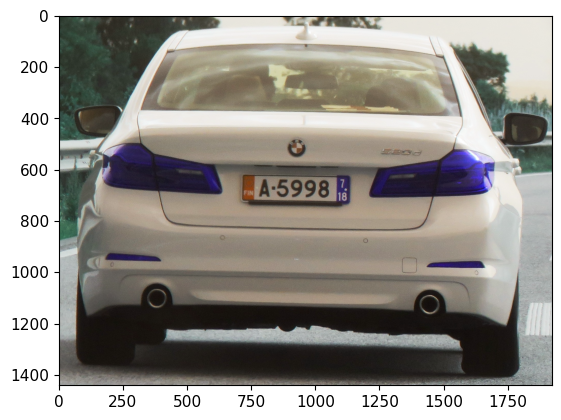

Segment License Plate


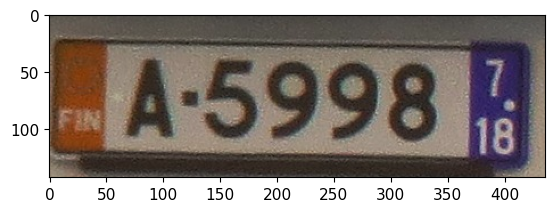

Remove Shadow


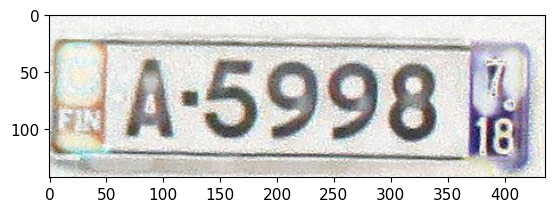

Blur


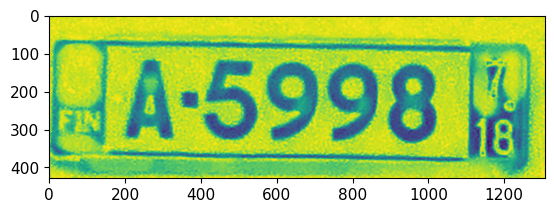

Dilate


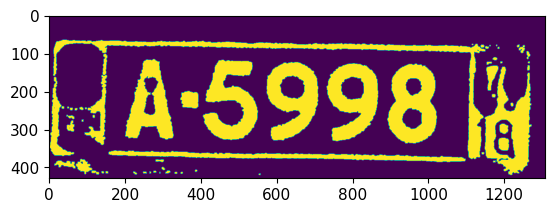

License Plate Number from Pytesseract OCR: A998Y
License Plate Number from My OCR: A5998


Original


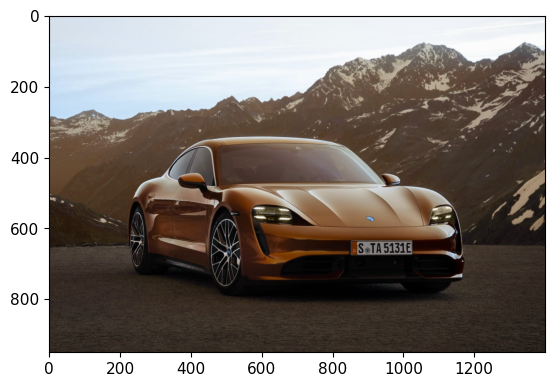

Segment License Plate


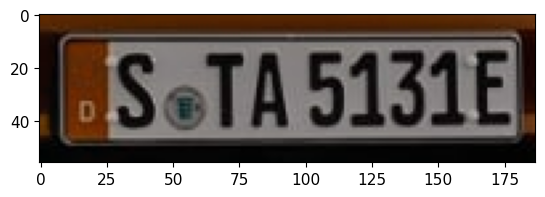

Remove Shadow


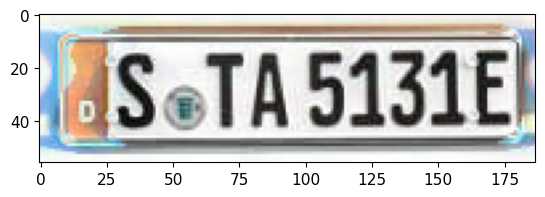

Blur


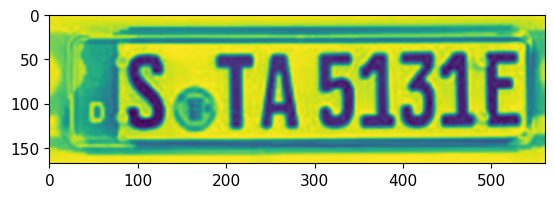

Dilate


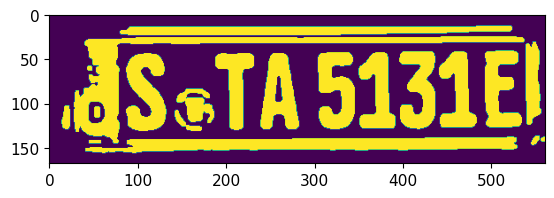

License Plate Number from Pytesseract OCR: STA5131E
License Plate Number from My OCR: STA5131E


Original


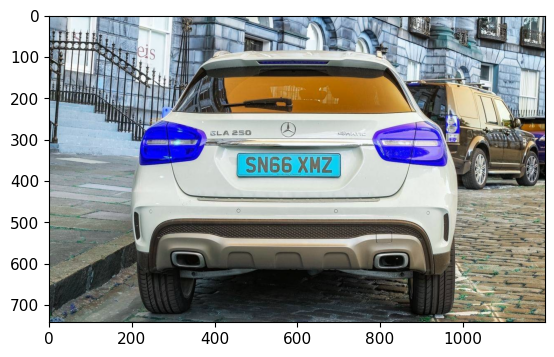

Segment License Plate


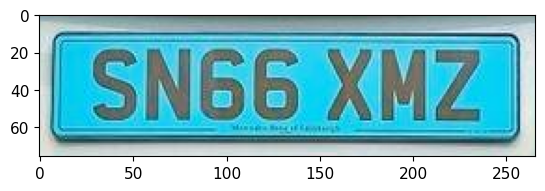

Remove Shadow


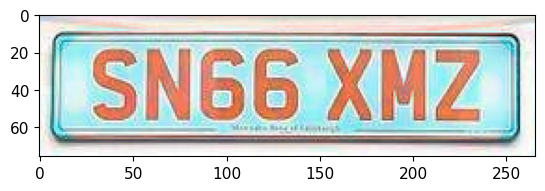

Blur


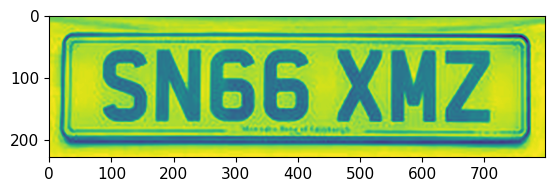

Dilate


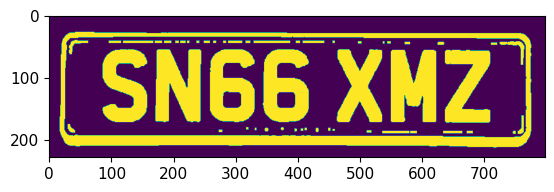

License Plate Number from Pytesseract OCR: SN66XMZ
License Plate Number from My OCR: SN66XMZ


Original


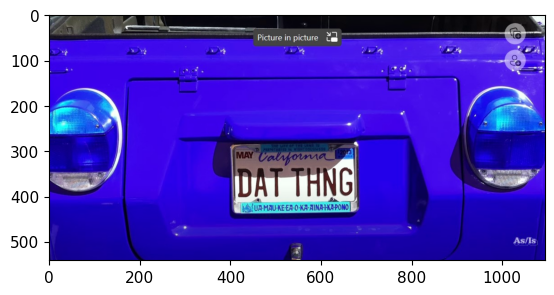

Segment License Plate


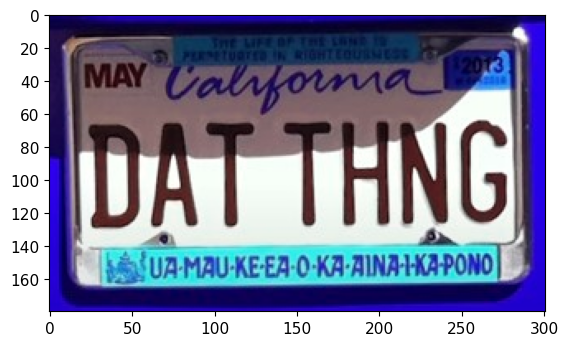

Remove Shadow


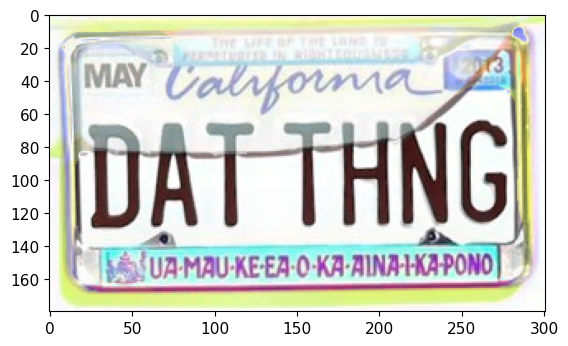

Blur


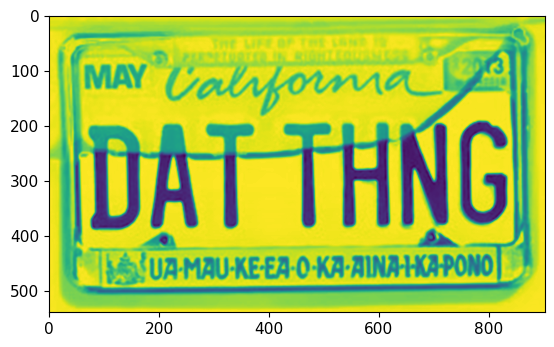

Dilate


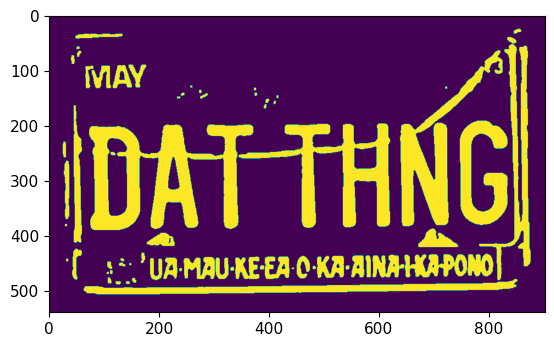

License Plate Number from Pytesseract OCR: KC5
License Plate Number from My OCR: DATTHNG




In [10]:
images = ['./images/license-plate.jpg', './images/license-plate2.jpg', 
          './images/license-plate3.jpg', './images/license-plate4.jpg']

for i in range(len(images)):
    my_image = cv2.imread(images[i])

    dilated, img_thresh, greyscale_img, my_text = dilate_image(my_image, license_plate, OCR)
    plate_number = ocr_license_plate(dilated, img_thresh, greyscale_img)
    print(f"License Plate Number from Pytesseract OCR: {plate_number}")
    print(F"License Plate Number from My OCR: {my_text}\n\n")